In [ ]:
# 🛠️ 1.1  Environment – install external libs (≈3 min) [for second time running the notebook - comment below line]
!pip -q install ydata-profiling keybert sentence-transformers rapidfuzz fastapi uvicorn torch

# 1.2  Imports & helpersimport pandas as pd, numpy as np, re, os, torch
import pandas as pd, numpy as np, re, os, torch
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm.auto import tqdm
from keybert import KeyBERT
from huggingface_hub import login
from collections import defaultdict
from rapidfuzz import process, fuzz
from ydata_profiling import ProfileReport
from sklearn.cluster import AgglomerativeClustering
from sentence_transformers import SentenceTransformer

In [ ]:
# 🛠️ 1.3  Upload & load data
from google.colab import files, drive
uploaded = files.upload()             # choose TV_sample.zip
!unzip -q TV_sample.zip -d tv_data

CSV_PATH = "tv_data/TV_sample.csv"
df = pd.read_csv(CSV_PATH)
print(df.shape)
df.head(3)


Saving TV_sample.zip to TV_sample (1).zip
replace tv_data/TV_sample.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
(366933, 13)


,asset_id,duration,name,season,episode,description,year,actors,director,country,content_type,imdbid,genre
0,35858224,20.0,Blu užuominos,1.0,1.0,"""Blu užuominos"" – tai interaktyvus lavinamasis...",2019.0,"Joshua Dela Cruz, Traci Paige Johnson, Steve B...","Vadim Kapridov, Jeremy Slutskin, M.R. Horhager...",JAV,series,tt9000424,"Adventure, Comedy, Animation"
1,35851511,60.0,Sūrus bučinys,0.0,1.0,Jauni įsimylėjėliai Hermanas ir Julija svajoja...,2022.0,"Anastasiya Ivanova, Maksym Samchyk, Svetlana Z...",Aleksandr Budyonny,NaN,series,NaN,Drama
2,35833932,45.0,Bones,1.0,6.0,"Brilliant, but socially inept, forensic anthro...",2005.0,"Emily Deschanel, David Boreanaz, Michaela Conl...","Maggie Parker, Tawnia McKiernan, Handel Whitmo...",JAV,series,tt0460627,Crime


In [ ]:
# 🕵🏻 1.4  Quick profiling (HTML saved to Colab Files)
profile = ProfileReport(df.sample(10000, random_state=42), title="TV Sample – Quick Profile")
profile.to_file("tv_profile.html")
print("📊 Profile ready – download from left pane ➜ Files ➜ tv_profile.html")


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|██████████| 13/13 [00:01<00:00, 12.89it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

📊 Profile ready – download from left pane ➜ Files ➜ tv_profile.html


In [ ]:
# 🧹 2.1  Basic cleaning helpers
def clean_text(s):
    if pd.isna(s): return np.nan
    s = re.sub(r"\s+", " ", str(s)).strip()
    s = re.sub(r"[“”\"']", "", s)
    return s

for col in ["name", "description", "actors", "director", "genre", "country"]:
    df[col] = df[col].apply(clean_text)

# Standardise content_type (movie/series/event/other)
def infer_type(row):
    if pd.notna(row["content_type"]): return row["content_type"]
    if re.search(r"(s\d+e\d+|episode|season)", str(row["name"]), re.I):
        return "series"
    if re.search(r"( vs |basket|football|euroleague|world cup)", str(row["name"]), re.I):
        return "event"
    return "movie"
df["content_type"] = df.apply(infer_type, axis=1)

# Impute year from name "(1999)" pattern
year_rx = re.compile(r"\((19|20)\d{2}\)")
df["year"] = df.apply(
    lambda r: r["year"] if pd.notna(r["year"]) else
    int(year_rx.search(r["name"]).group(0)[1:-1]) if year_rx.search(r["name"]) else np.nan,
    axis=1
)


In [ ]:
# ⚡ 📝 3.1  Fast, batched keyword extraction (GPU-aware & HF-authenticated)

# ① Authenticate once (expects HF_TOKEN saved in Colab “Secrets” or env var)
login(token=os.getenv("HF_TOKEN"))      # Tools ▸ Secrets ▸ add HF_TOKEN

# ② Pick device and load models (first pull is ~90 MB ⇒ 1-2 min with token)
device = "cuda" if torch.cuda.is_available() else "cpu"
embed_model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2", device=device)
kw_model    = KeyBERT(model=embed_model)

# ③ Batched extraction to avoid per-row overhead
def extract_keywords_batched(texts, batch_size=512, top_n=5):
    """
    texts: list[str]  →  returns list[list[str]] of keywords per doc.
    Uses MMR for diversity and processes up to `batch_size` docs at once.
    """
    results = []
    for start in tqdm(range(0, len(texts), batch_size)):
        chunk = texts[start:start + batch_size]
        kw_chunk = kw_model.extract_keywords(
            chunk,
            keyphrase_ngram_range=(1, 2),
            stop_words="english",
            top_n=top_n,
            use_mmr=True           # diversify phrases
        )
        # kw_chunk is list[list[(kw, score)]] – keep only kw strings
        results.extend([[kw for kw, _ in doc] for doc in kw_chunk])
    return results

# ④ Run on the whole column (2-3 × faster on GPU; ~5 × faster than row-loop)
descriptions = df["description"].fillna("").tolist()
df["keywords"] = extract_keywords_batched(descriptions, batch_size=512, top_n=5)

model = embed_model     # <-- alias so the old code still works


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


  0%|          | 0/717 [00:00<?, ?it/s]

In [ ]:
# 🕸️ 4.1  Robust record-linkage — SBERT embeddings reused, cosine distance allowed

# --- helpers ---------------------------------------------------------------
def normalise_title(text: str) -> str:
    """Low-case, strip non-alphanum, collapse spaces."""
    return re.sub(r"[^a-z0-9]+", " ", str(text).lower()).strip()

def encode_texts(texts, batch=1024):
    """Vectorise a list of strings on GPU/CPU in batches."""
    chunks = [
        embed_model.encode(
            texts[i:i + batch],
            convert_to_tensor=True,
            show_progress_bar=False,
            batch_size=batch,
        )
        for i in range(0, len(texts), batch)
    ]
    return torch.cat(chunks).cpu().numpy()

# --- 4 · 1-a  normalise titles & build blocks ------------------------------
df["title_norm"] = df["name"].apply(normalise_title)

blocks = defaultdict(list)
for idx, key in enumerate(df["title_norm"].str[:25]):   # first 25 chars
    blocks[key].append(idx)

# --- 4 · 1-b  cluster each block -------------------------------------------
cluster_ids  = np.full(len(df), -1, dtype=int)
next_cluster = 0

for idxs in tqdm(blocks.values(), desc="Clustering blocks"):
    if len(idxs) == 1:                     # singleton ➜ its own cluster
        cluster_ids[idxs[0]] = next_cluster
        next_cluster += 1
        continue

    emb = encode_texts(df.loc[idxs, "title_norm"].tolist(), batch=512)

    clu = AgglomerativeClustering(
        n_clusters        = None,
        distance_threshold= 0.45,          # tune ≥0 ⇢ looser, ≤0 ⇢ stricter
        metric            = "cosine",      # OK because we choose linkage="average"
        linkage           = "average",
    ).fit(emb)

    cluster_ids[idxs] = next_cluster + clu.labels_
    next_cluster     += clu.labels_.max() + 1

df["cluster_id"] = cluster_ids
print(f"✅ Created {df['cluster_id'].nunique():,} content clusters")



Clustering blocks:   0%|          | 0/17199 [00:00<?, ?it/s]

✅ Created 17,212 content clusters


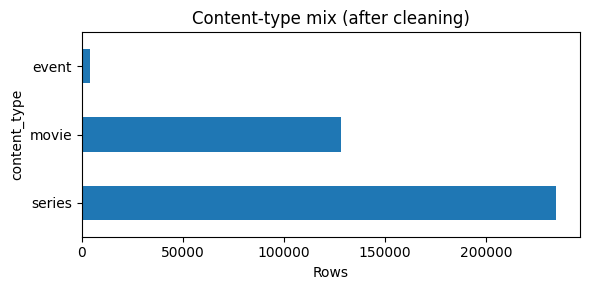

,percent_missing
imdbid,63.8
director,57.0
country,56.9
actors,52.9
genre,47.9
year,34.0
description,7.1
asset_id,0.0
episode,0.0
duration,0.0


In [ ]:
# 📈 5.1  Basic post-clean snapshots

# Content-type mix
ax = df["content_type"].value_counts().plot(
    kind="barh", figsize=(6,3),
    title="Content-type mix (after cleaning)"
)
ax.set_xlabel("Rows"); plt.tight_layout(); plt.show()

# Missingness
missing = (df.isna().mean()*100).round(1).sort_values(ascending=False)
display(missing.head(10).to_frame("percent_missing"))


In [ ]:
# 💾 6.1  Save to compressed Parquet
OUT_PATH = "tv_data_cleaned.parquet"
df.to_parquet(OUT_PATH, index=False)
size_mb = round(os.path.getsize(OUT_PATH) / 1_048_576, 1)
print(f"💾 Saved {OUT_PATH}  ({size_mb} MB)")


💾 Saved tv_data_cleaned.parquet  (134.9 MB)
